# <center> Telco Customer Churn

### What does churn stand for?

Churn in a business setting refers to losing an acquired, protentially profitable customer.
The definition of churn can vary by industry(in healthcare, dead people are considered churn 
while in finance, people with inactive card are called churned).

### Why do businesses want to prevent churn?

Acquiring a new customer is always more expensive than retaining an exsiting 
one. Hence, not letting them churn is the key to a sustained revenue stream.

### What metrics do we optimize on while predicting them?

F1 score, Recall, and PR curves

### ML Model Goals

- predicting churn
- finding what metrics impact most on churn

## Preprocessing

In [42]:
import numpy as np
import pandas as pd

In [43]:
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [44]:
pd.set_option('max_colwidth',200)
tcc.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [45]:
tcc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [46]:
tcc['customerID'].nunique() == tcc.shape[0]

True

In [47]:
tcc.duplicated().sum() #row by row

0

- check missing value

In [48]:
tcc.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [49]:
def missing (df):
    """
    Calculate the missing values and missing percentage for each column
    """
    missing_number = df.isnull().sum().sort_values(ascending=False)                            
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)        
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])  
    return missing_values

In [50]:
missing(tcc)

,Missing_Number,Missing_Percent
customerID,0,0.0
DeviceProtection,0,0.0
TotalCharges,0,0.0
MonthlyCharges,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0


We can find that there is no missing value in this dataset

In [51]:
tcc['tenure']

0        1
1       34
2        2
3       45
4        2
        ..
7038    24
7039    72
7040    11
7041     4
7042    66
Name: tenure, Length: 7043, dtype: int64

In [52]:
tcc['tenure'].nunique()

73

In [53]:
#discrete metrics
category_cols = ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

#numeric metrics
numeric_cols = ['MonthlyCharges', 'TotalCharges']

# label
target = 'Churn'

assert len(category_cols) + len(numeric_cols) + 1 == tcc.shape[1]

In [54]:
tcc[numeric_cols].astype(float)

ValueError: could not convert string to float: ''

In [55]:
def find_index(data_col, val):
    """
    Query the index of the first occurrence of a value in a column, otherwise return -1
    
    :param data_col: given columns
    :param val: the value you are looking for
    """
    val_list = [val]
    if data_col.isin(val_list).sum() == 0:
        index = -1
    else:
        index = data_col.isin(val_list).idxmax()
    return index

In [56]:
for col in numeric_cols:
    print(find_index(tcc[col], ' '))

-1
488


In [57]:
tcc['TotalCharges'].iloc[488]

' '

In [58]:
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

In [59]:
missing(tcc[numeric_cols])

,Missing_Number,Missing_Percent
TotalCharges,11,0.001562
MonthlyCharges,0,0.000000


In [60]:
tcc[tcc['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [61]:
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

In [62]:
tcc['TotalCharges'].isnull().sum()

0

In [63]:
tcc['TotalCharges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

In [64]:
tcc.select_dtypes('object').columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [65]:
tcc[category_cols].nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
dtype: int64

In [66]:
for feature in tcc[category_cols]:
        print(f'{feature}: {tcc[feature].unique()}')

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

- check outliers

In [67]:
tcc[numeric_cols].describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


three sigma

In [68]:
tcc['MonthlyCharges'].mean() + 3 * tcc['MonthlyCharges'].std() 

155.03183375363483

In [69]:
tcc['MonthlyCharges'].mean() - 3 * tcc['MonthlyCharges'].std()

-25.5084488324364

In [70]:
tcc['TotalCharges'].mean() + 3 * tcc['TotalCharges'].std() 

9080.117712630885

In [71]:
tcc['TotalCharges'].mean() - 3 * tcc['TotalCharges'].std() 

-4520.649105503233

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0, 'TotalCharges')

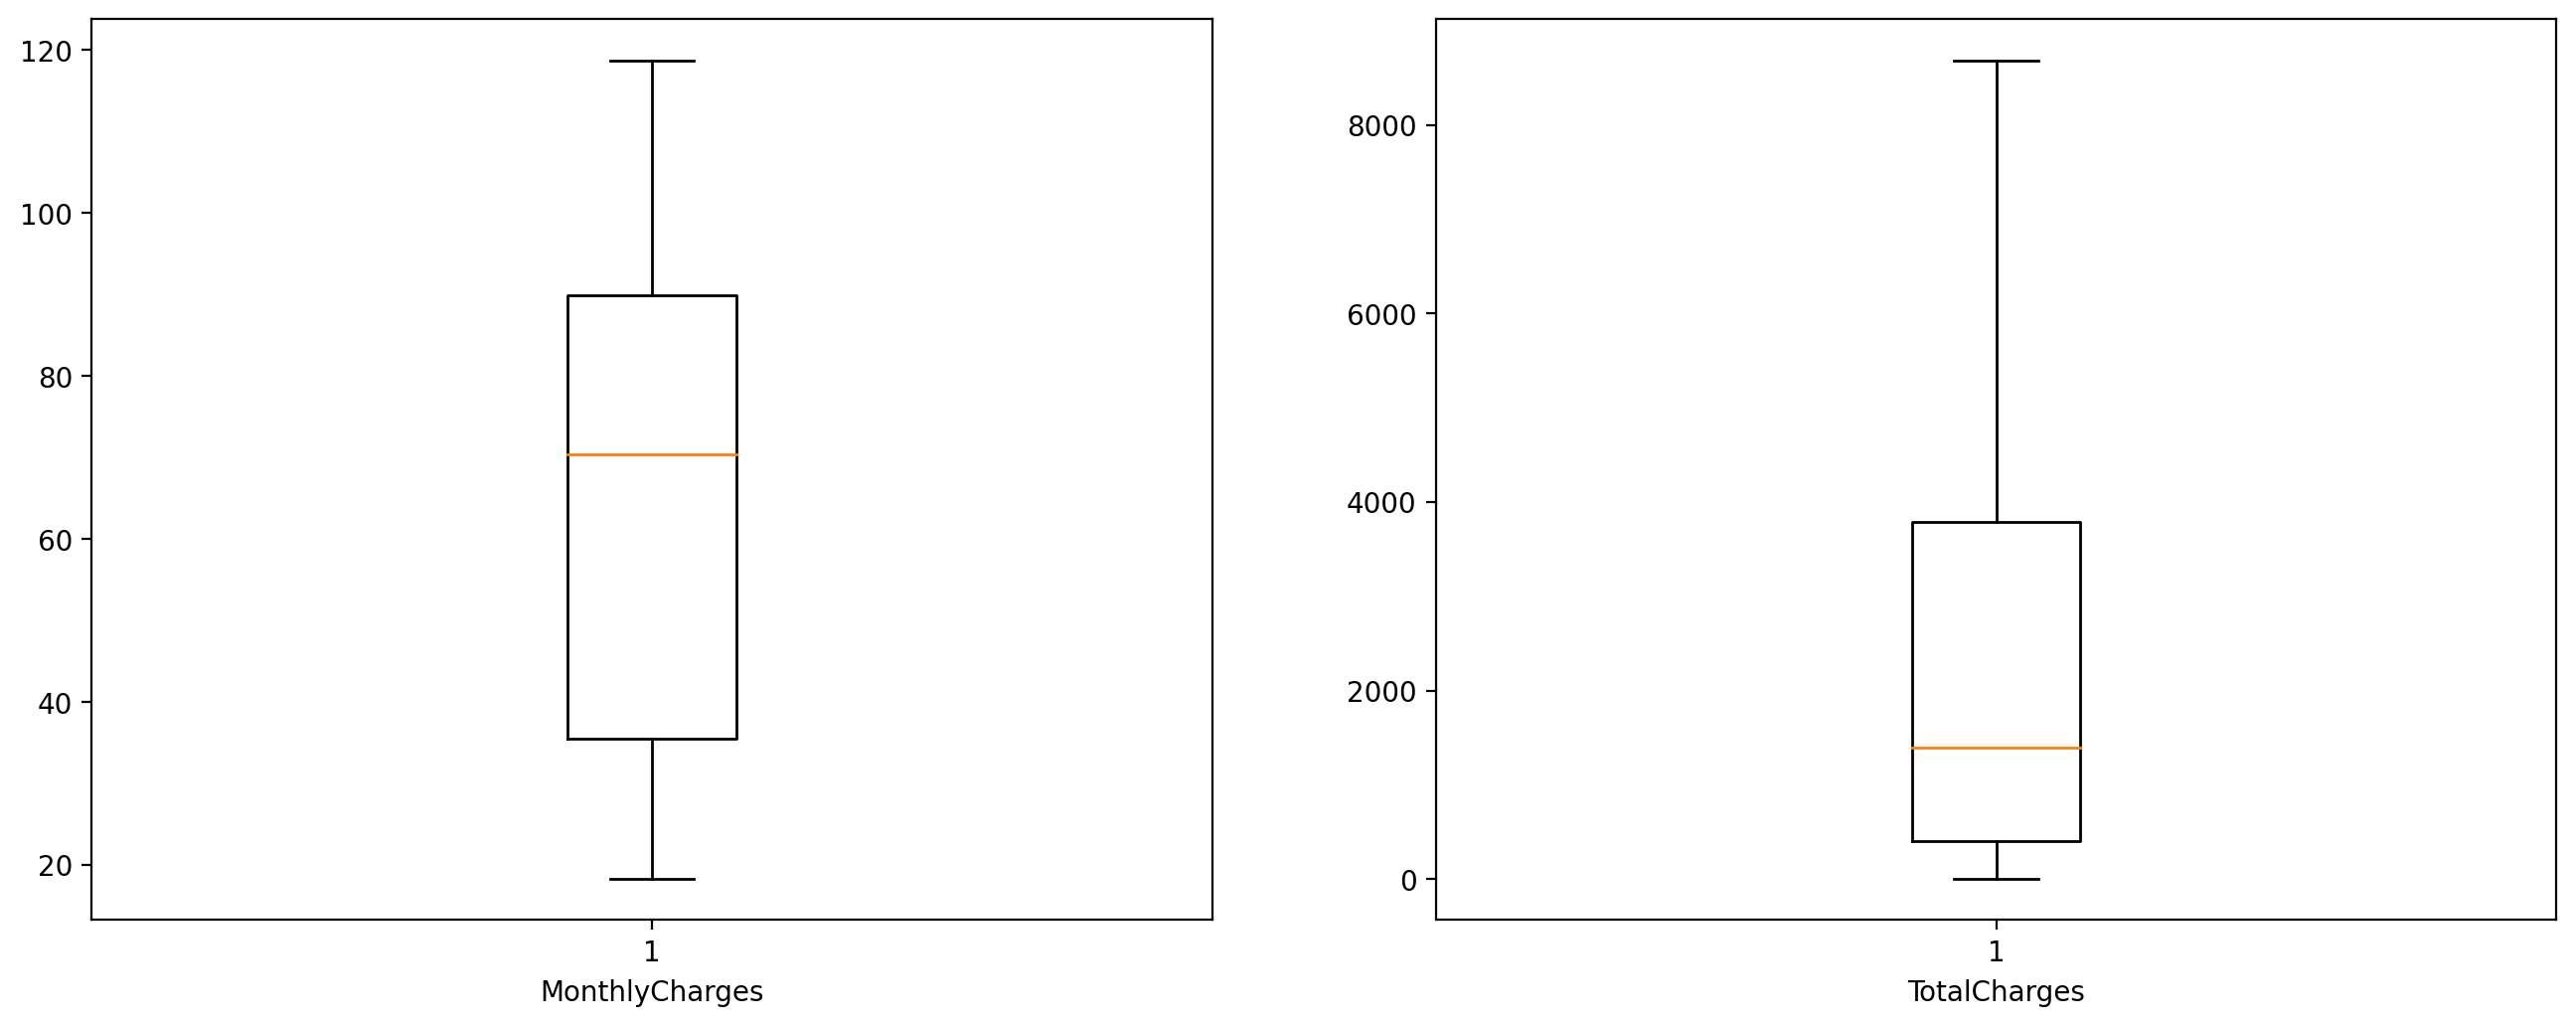

In [73]:
plt.figure(figsize=(16, 6), dpi=200)
plt.subplot(121)
plt.boxplot(tcc['MonthlyCharges'])
plt.xlabel('MonthlyCharges')
plt.subplot(122)
plt.boxplot(tcc['TotalCharges'])
plt.xlabel('TotalCharges')

by boxplot and three sigma, we can see that there are no outiers in this dataset

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

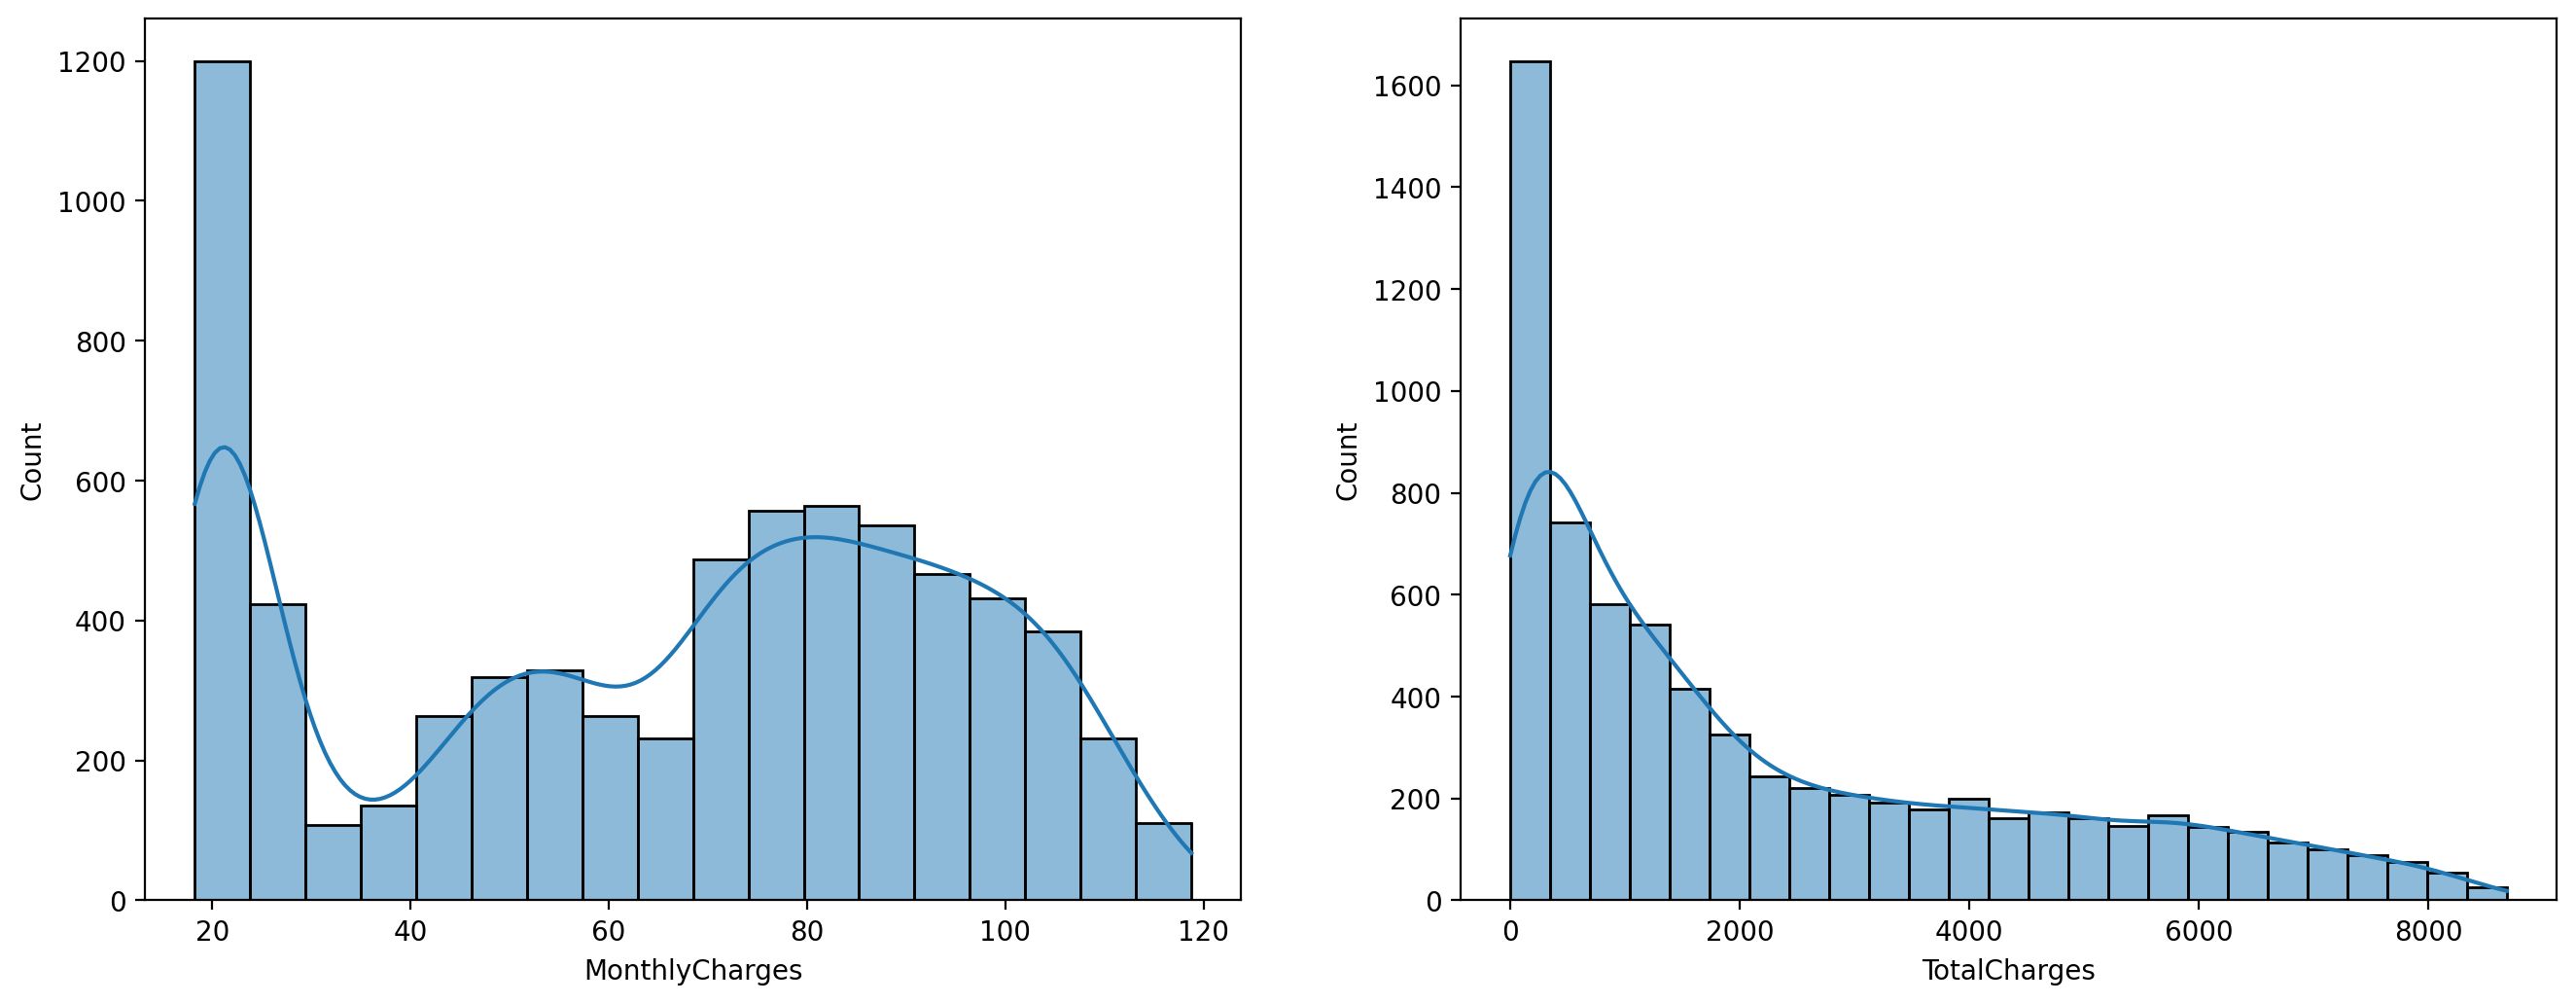

In [74]:
plt.figure(figsize=(16, 6), dpi=200)
plt.subplot(121)
sns.histplot(tcc['MonthlyCharges'], kde=True) 
plt.subplot(122)
sns.histplot(tcc['TotalCharges'], kde=True)

## EDA

In [75]:
y = tcc['Churn']
print(f'Percentage of Churn:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} customer)\nPercentage of customer did not churn: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} customer)')

Percentage of Churn:  26.54 %  --> (1869 customer)
Percentage of customer did not churn: 73.46  %  --> (5174 customer)


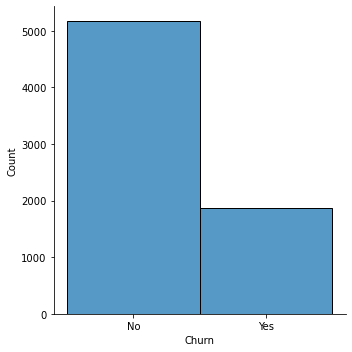

In [76]:
sns.displot(y)

In [77]:
# remove ID column
df3 = tcc.iloc[:,1:].copy()

# transform Yes/No to 1/0
df3['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df3['Churn'].replace(to_replace='No',  value=0, inplace=True)

#transform all discrete variables to dummies, numeric variables keep the same
df_dummies = pd.get_dummies(df3)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [78]:
df_dummies[['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']]

,Churn,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,1,2,53.85,108.15
3,0,45,42.30,1840.75
4,1,2,70.70,151.65
...,...,...,...,...
7038,0,24,84.80,1990.50
7039,0,72,103.20,7362.90
7040,0,11,29.60,346.45
7041,1,4,74.40,306.60


In [79]:
df_dummies.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
SeniorCitizen,1.000000,0.016567,0.220173,0.103006,0.150889,0.001874,-0.001874,-0.016479,0.016479,0.211185,...,0.120176,0.138360,-0.046262,-0.117000,-0.156530,0.156530,-0.016159,-0.024135,0.171718,-0.153477
tenure,0.016567,1.000000,0.247900,0.826178,-0.352229,-0.005106,0.005106,-0.379697,0.379697,-0.159712,...,0.286111,-0.645561,0.202570,0.558533,-0.006152,0.006152,0.243510,0.233006,-0.208363,-0.233852
MonthlyCharges,0.220173,0.247900,1.000000,0.651174,0.193356,0.014569,-0.014569,-0.096848,0.096848,0.113890,...,0.627429,0.060165,0.004904,-0.074681,-0.352150,0.352150,0.042812,0.030550,0.271625,-0.377437
TotalCharges,0.103006,0.826178,0.651174,1.000000,-0.198324,0.000080,-0.000080,-0.317504,0.317504,-0.062078,...,0.520122,-0.444255,0.170814,0.354481,-0.158574,0.158574,0.185987,0.182915,-0.059246,-0.295758
Churn,0.150889,-0.352229,0.193356,-0.198324,1.000000,0.008612,-0.008612,0.150448,-0.150448,0.164221,...,0.061382,0.405103,-0.177820,-0.302253,-0.191825,0.191825,-0.117937,-0.134302,0.301919,-0.091683
gender_Female,0.001874,-0.005106,0.014569,0.000080,0.008612,1.000000,-1.000000,-0.001808,0.001808,0.010517,...,0.010487,0.003386,-0.008026,0.003695,-0.011754,0.011754,0.016024,-0.001215,-0.000752,-0.013744
gender_Male,-0.001874,0.005106,-0.014569,-0.000080,-0.008612,-1.000000,1.000000,0.001808,-0.001808,-0.010517,...,-0.010487,-0.003386,0.008026,-0.003695,0.011754,-0.011754,-0.016024,0.001215,0.000752,0.013744
Partner_No,-0.016479,-0.379697,-0.096848,-0.317504,0.150448,-0.001808,0.001808,1.000000,-1.000000,0.452676,...,-0.117412,0.280865,-0.082783,-0.248091,-0.014877,0.014877,-0.110706,-0.082029,0.083852,0.095125
Partner_Yes,0.016479,0.379697,0.096848,0.317504,-0.150448,0.001808,-0.001808,-1.000000,1.000000,-0.452676,...,0.117412,-0.280865,0.082783,0.248091,0.014877,-0.014877,0.110706,0.082029,-0.083852,-0.095125
Dependents_No,0.211185,-0.159712,0.113890,-0.062078,0.164221,0.010517,-0.010517,0.452676,-0.452676,1.000000,...,0.039741,0.231720,-0.068368,-0.204613,-0.111377,0.111377,-0.052021,-0.060267,0.150642,-0.059071


In [80]:
df_dummies.corr()['Churn'].sort_values(ascending = False)

Churn                                      1.000000
Contract_Month-to-month                    0.405103
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
MonthlyCharges                             0.193356
PaperlessBilling_Yes                       0.191825
Dependents_No                              0.164221
SeniorCitizen                              0.150889
Partner_No                                 0.150448
StreamingMovies_No                         0.130845
StreamingTV_No                             0.128916
StreamingTV_Yes                            0.063228
StreamingMovies_Yes                        0.061382
MultipleLines_Yes                          0.040102
PhoneService_Yes                           0.011942
gender_Femal

<AxesSubplot:>

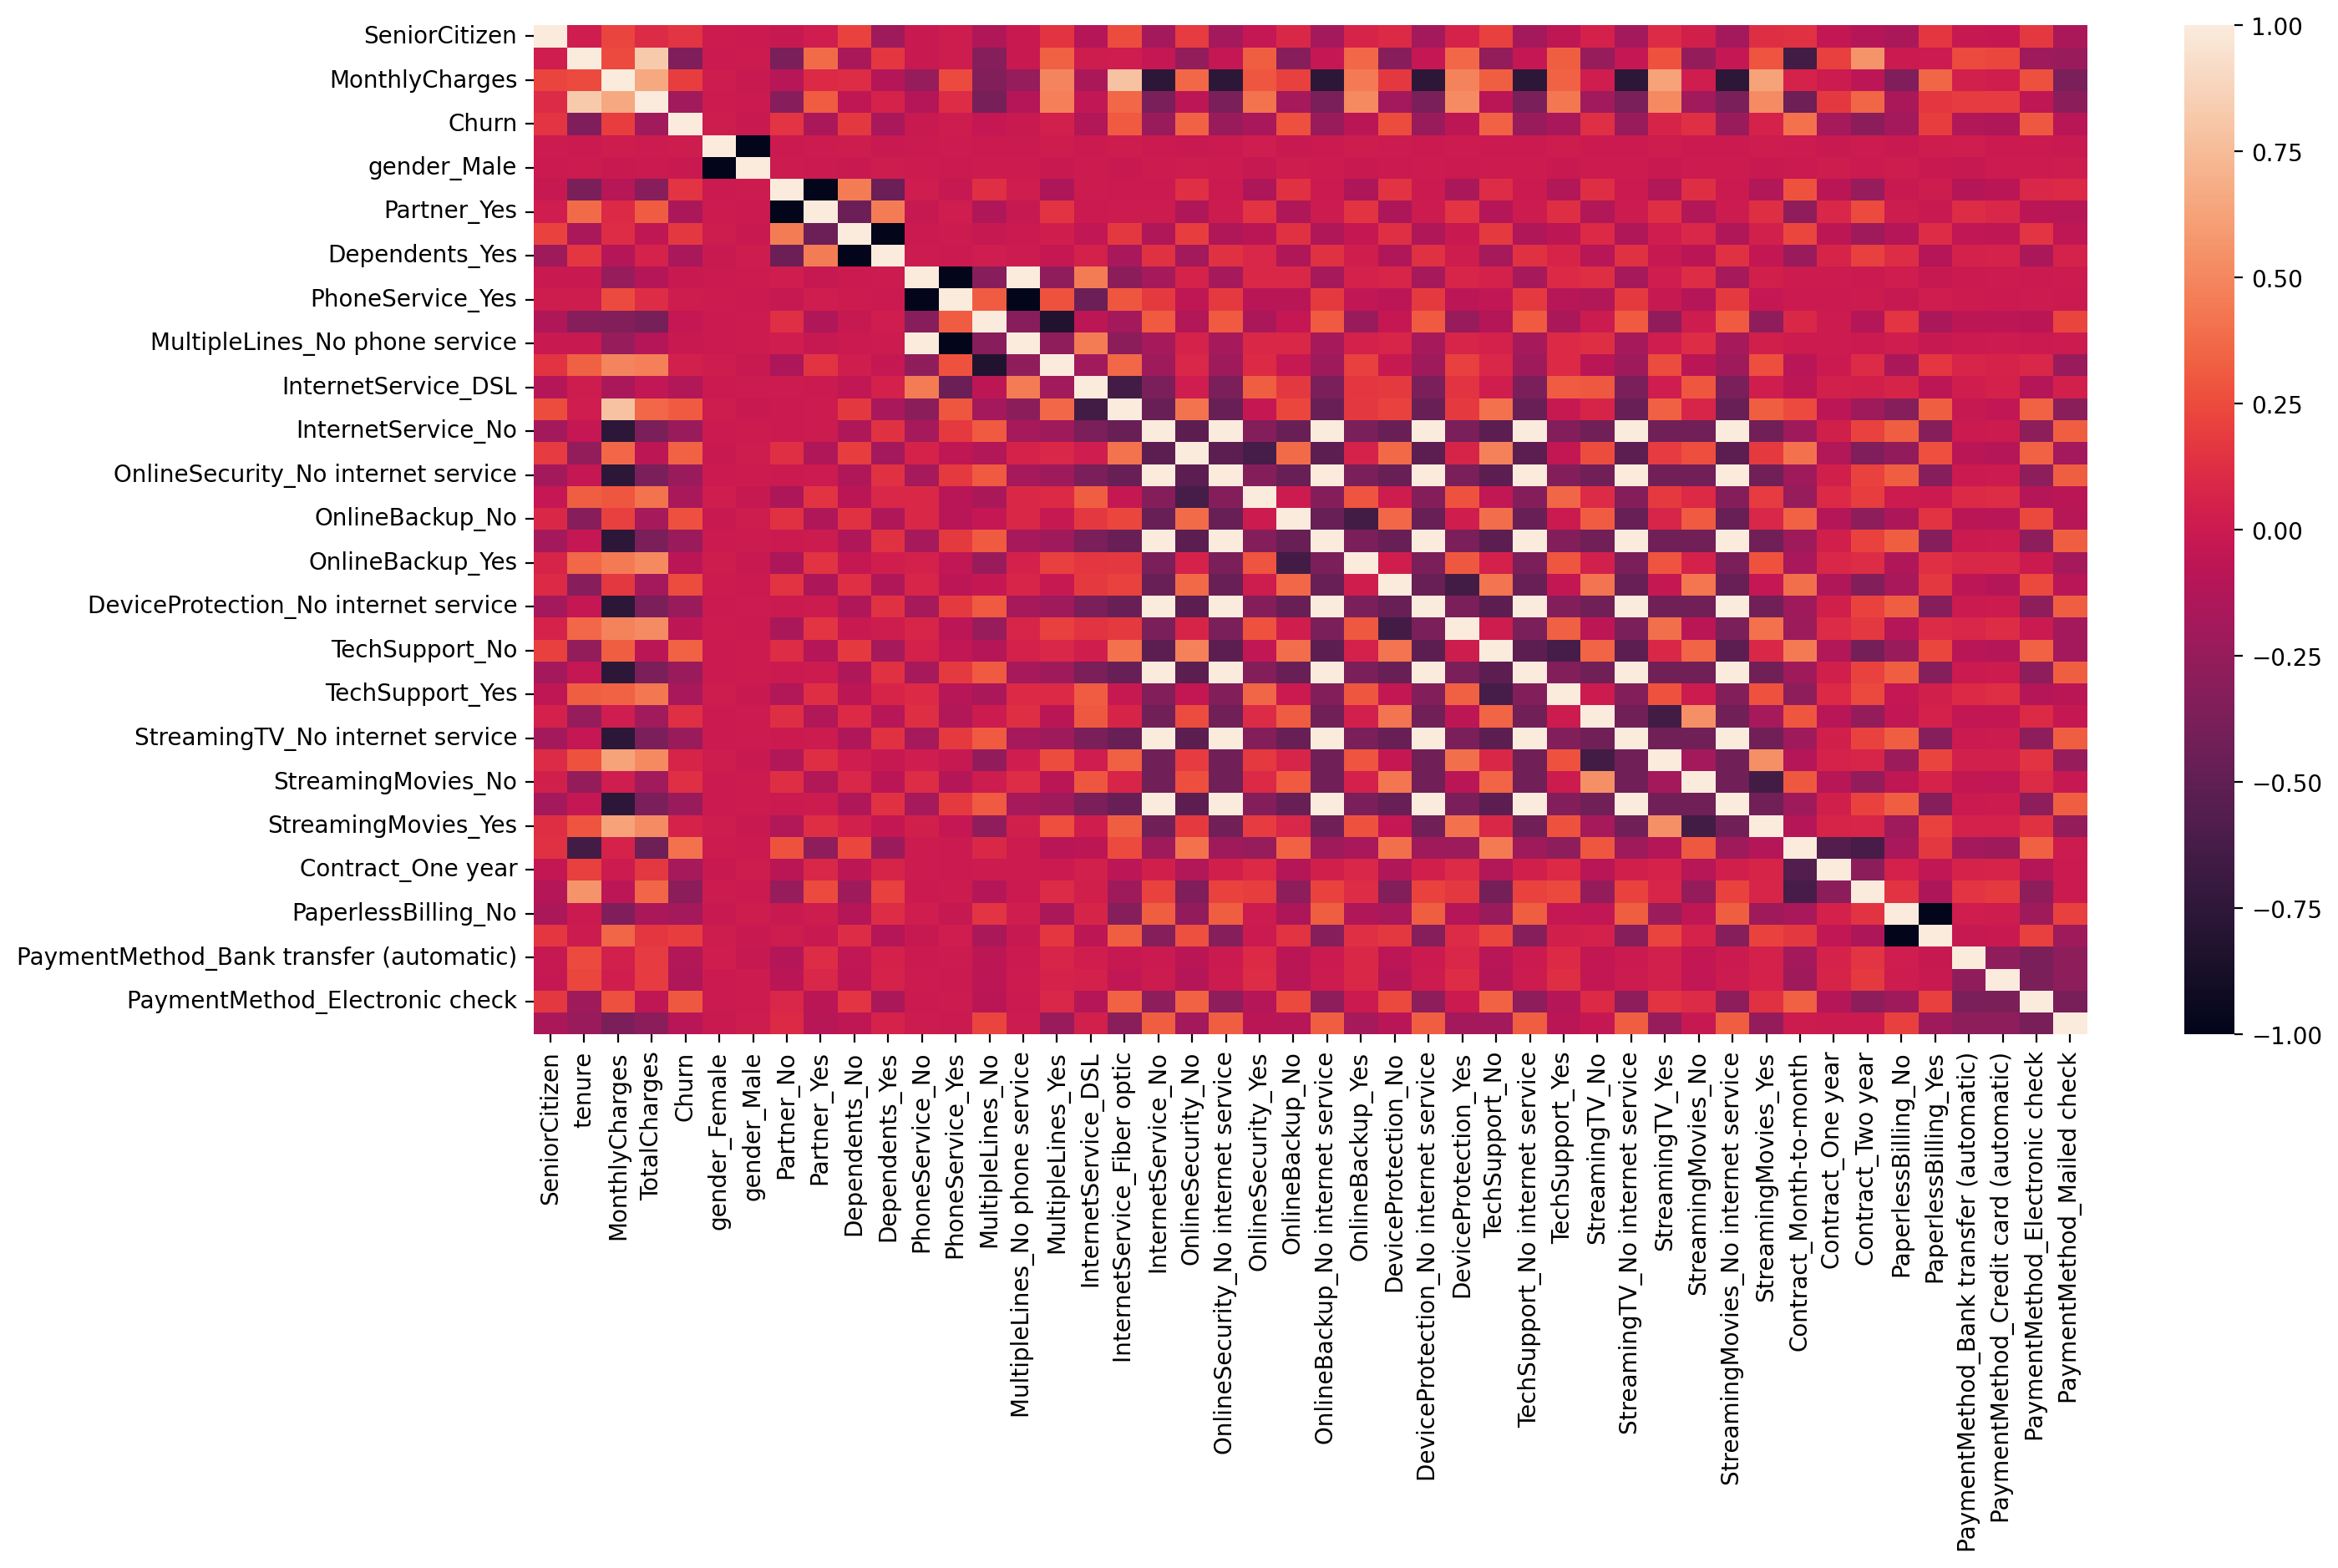

In [81]:
plt.figure(figsize=(15,8), dpi=200)
sns.heatmap (df_dummies.corr())

<AxesSubplot:>

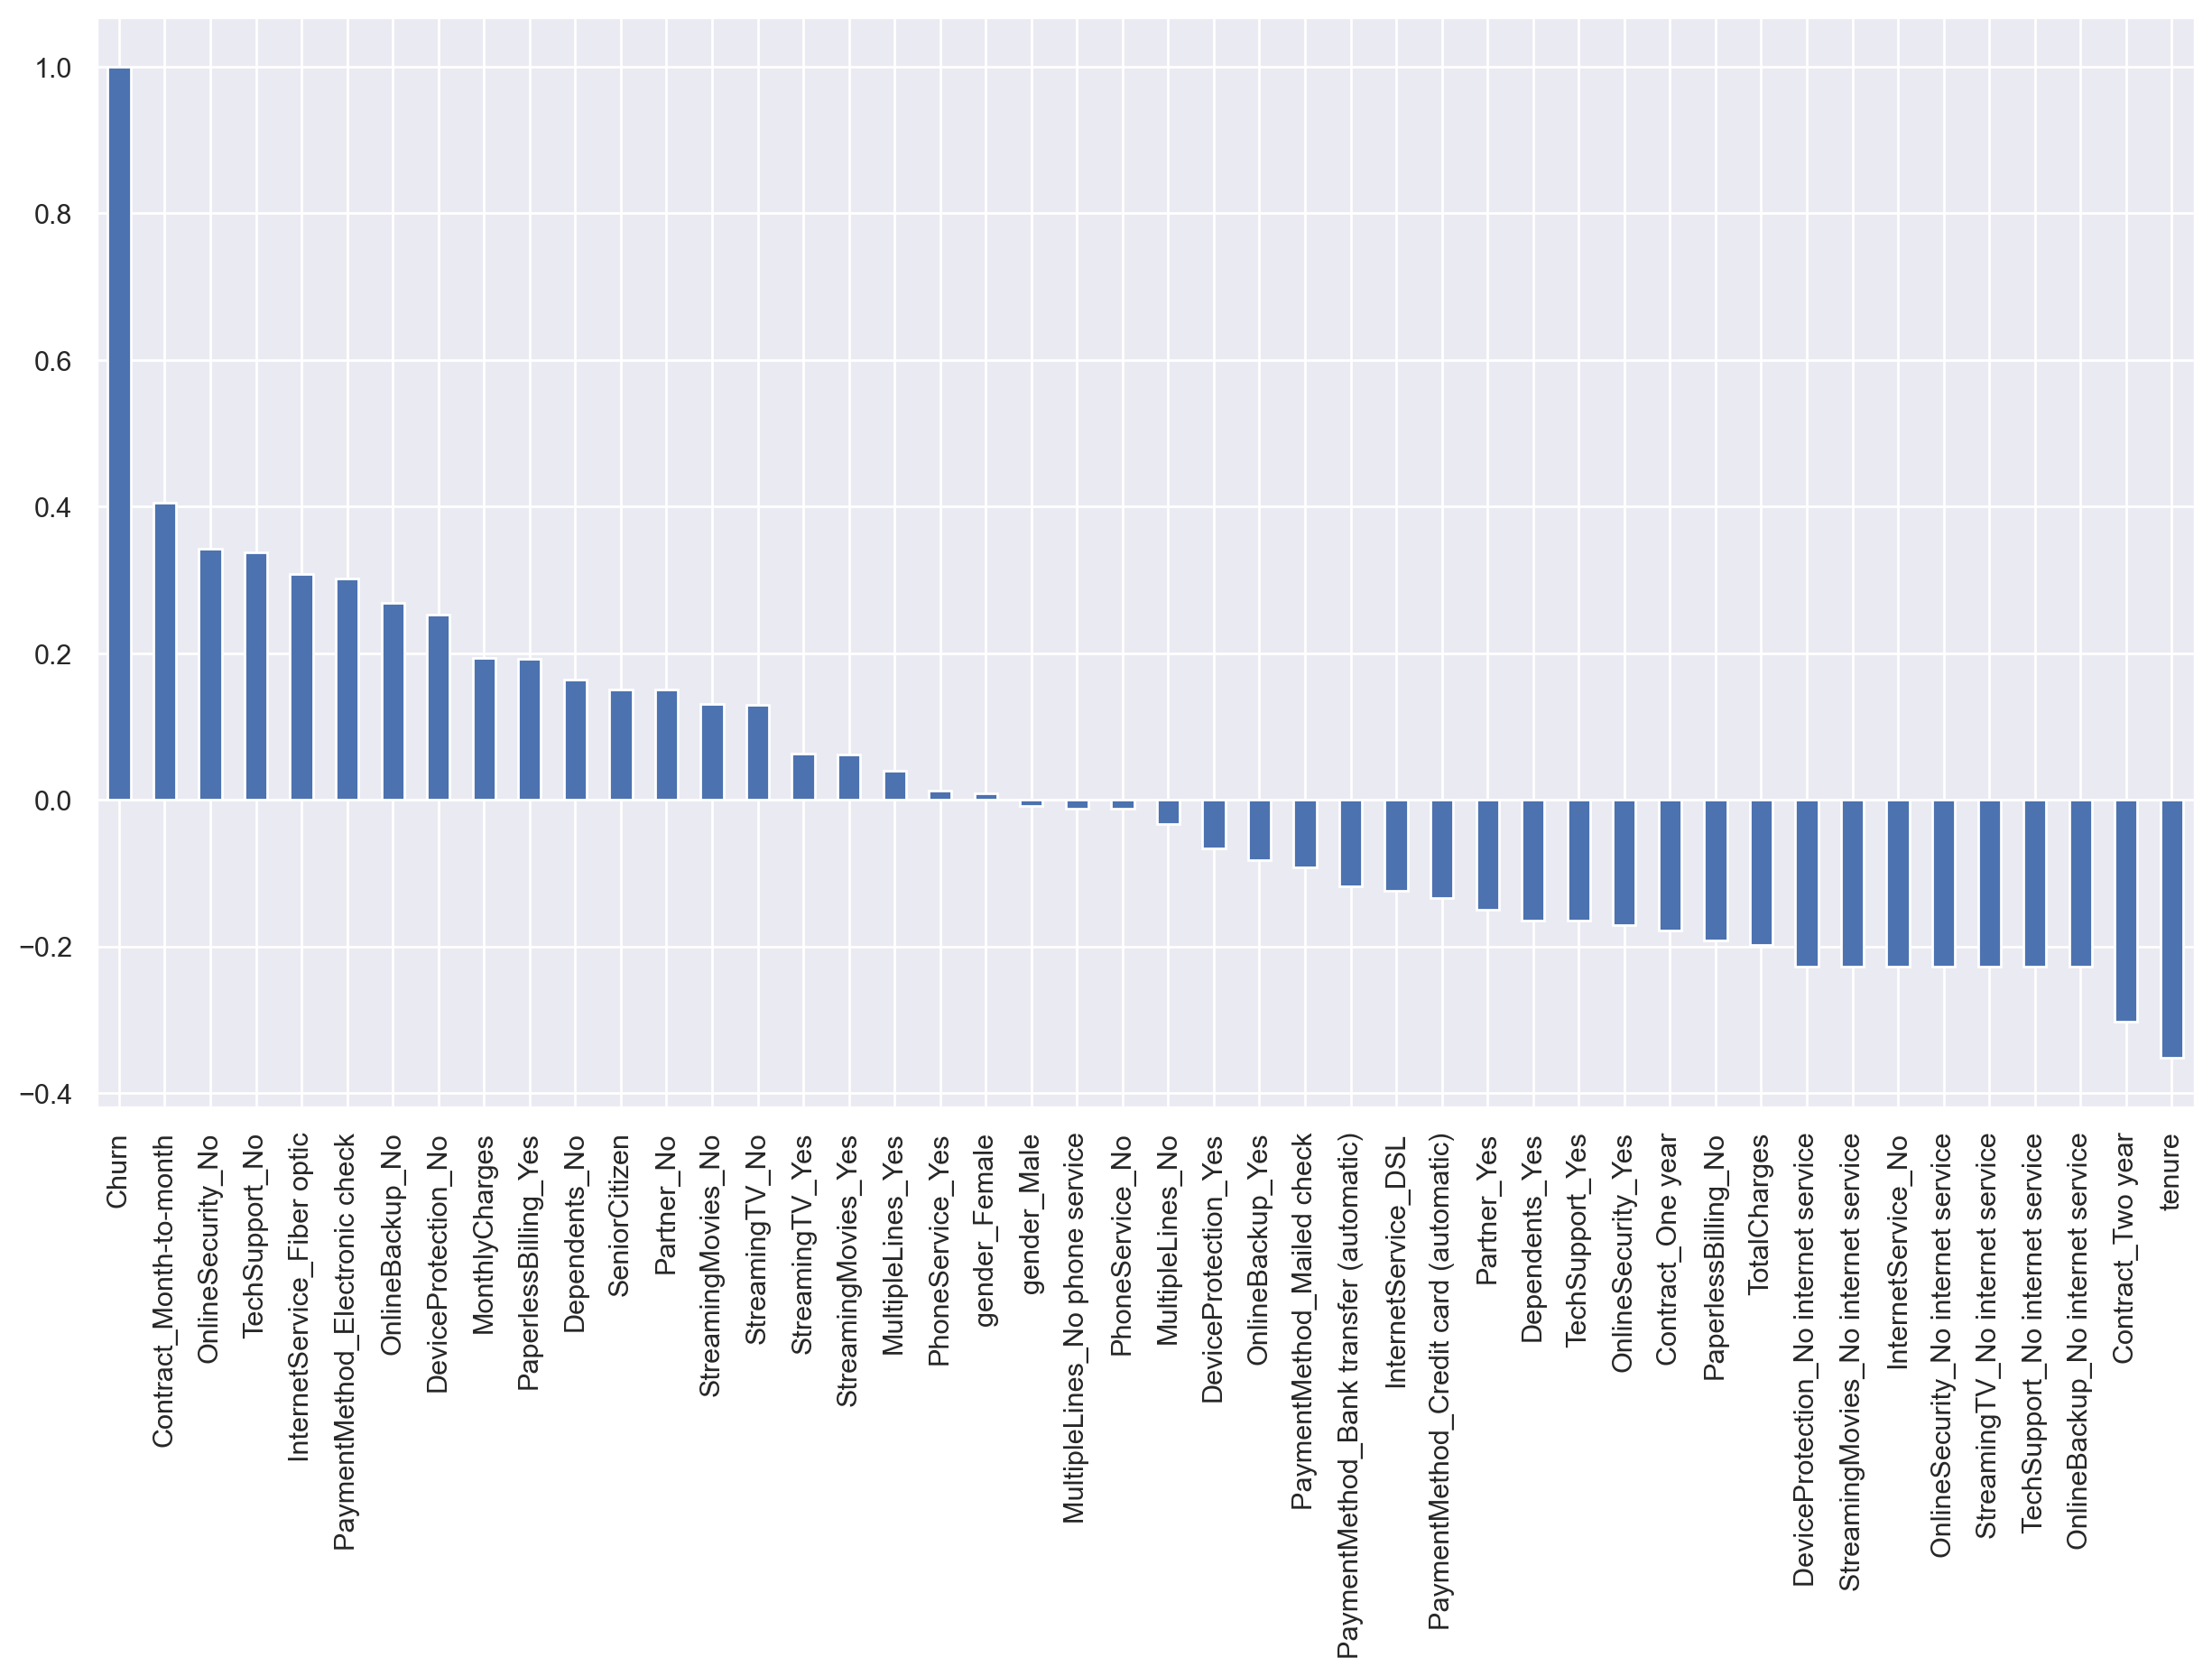

In [82]:
sns.set()
plt.figure(figsize=(15,8), dpi=200)

df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Text(0.5, 1.0, 'Churn by Gender')

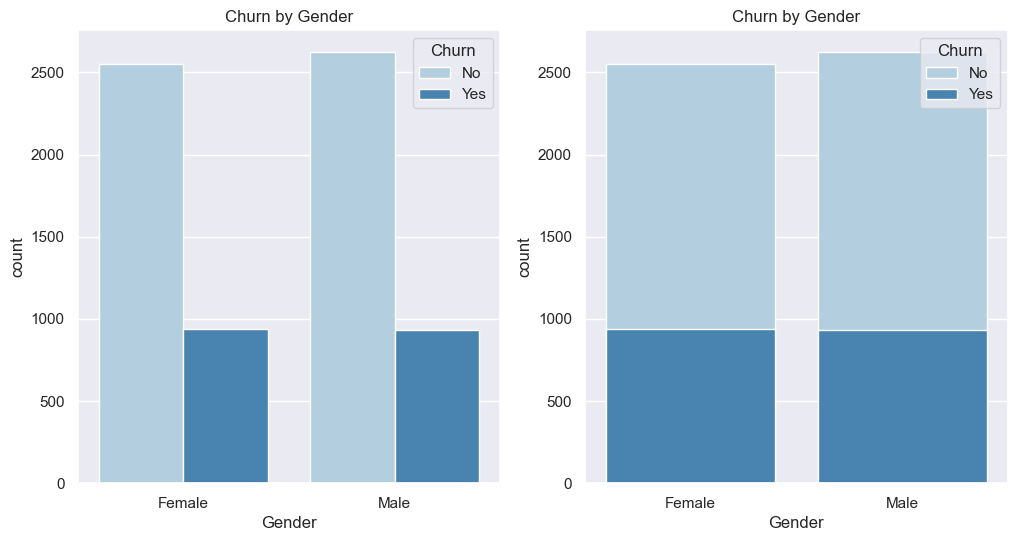

In [83]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,6), dpi=100)


plt.subplot(121)
sns.countplot(x="gender",hue="Churn",data=tcc,palette="Blues", dodge=True)
plt.xlabel("Gender")
plt.title("Churn by Gender")


plt.subplot(122)
sns.countplot(x="gender",hue="Churn",data=tcc,palette="Blues", dodge=False)
plt.xlabel("Gender")
plt.title("Churn by Gender")

- Customer info

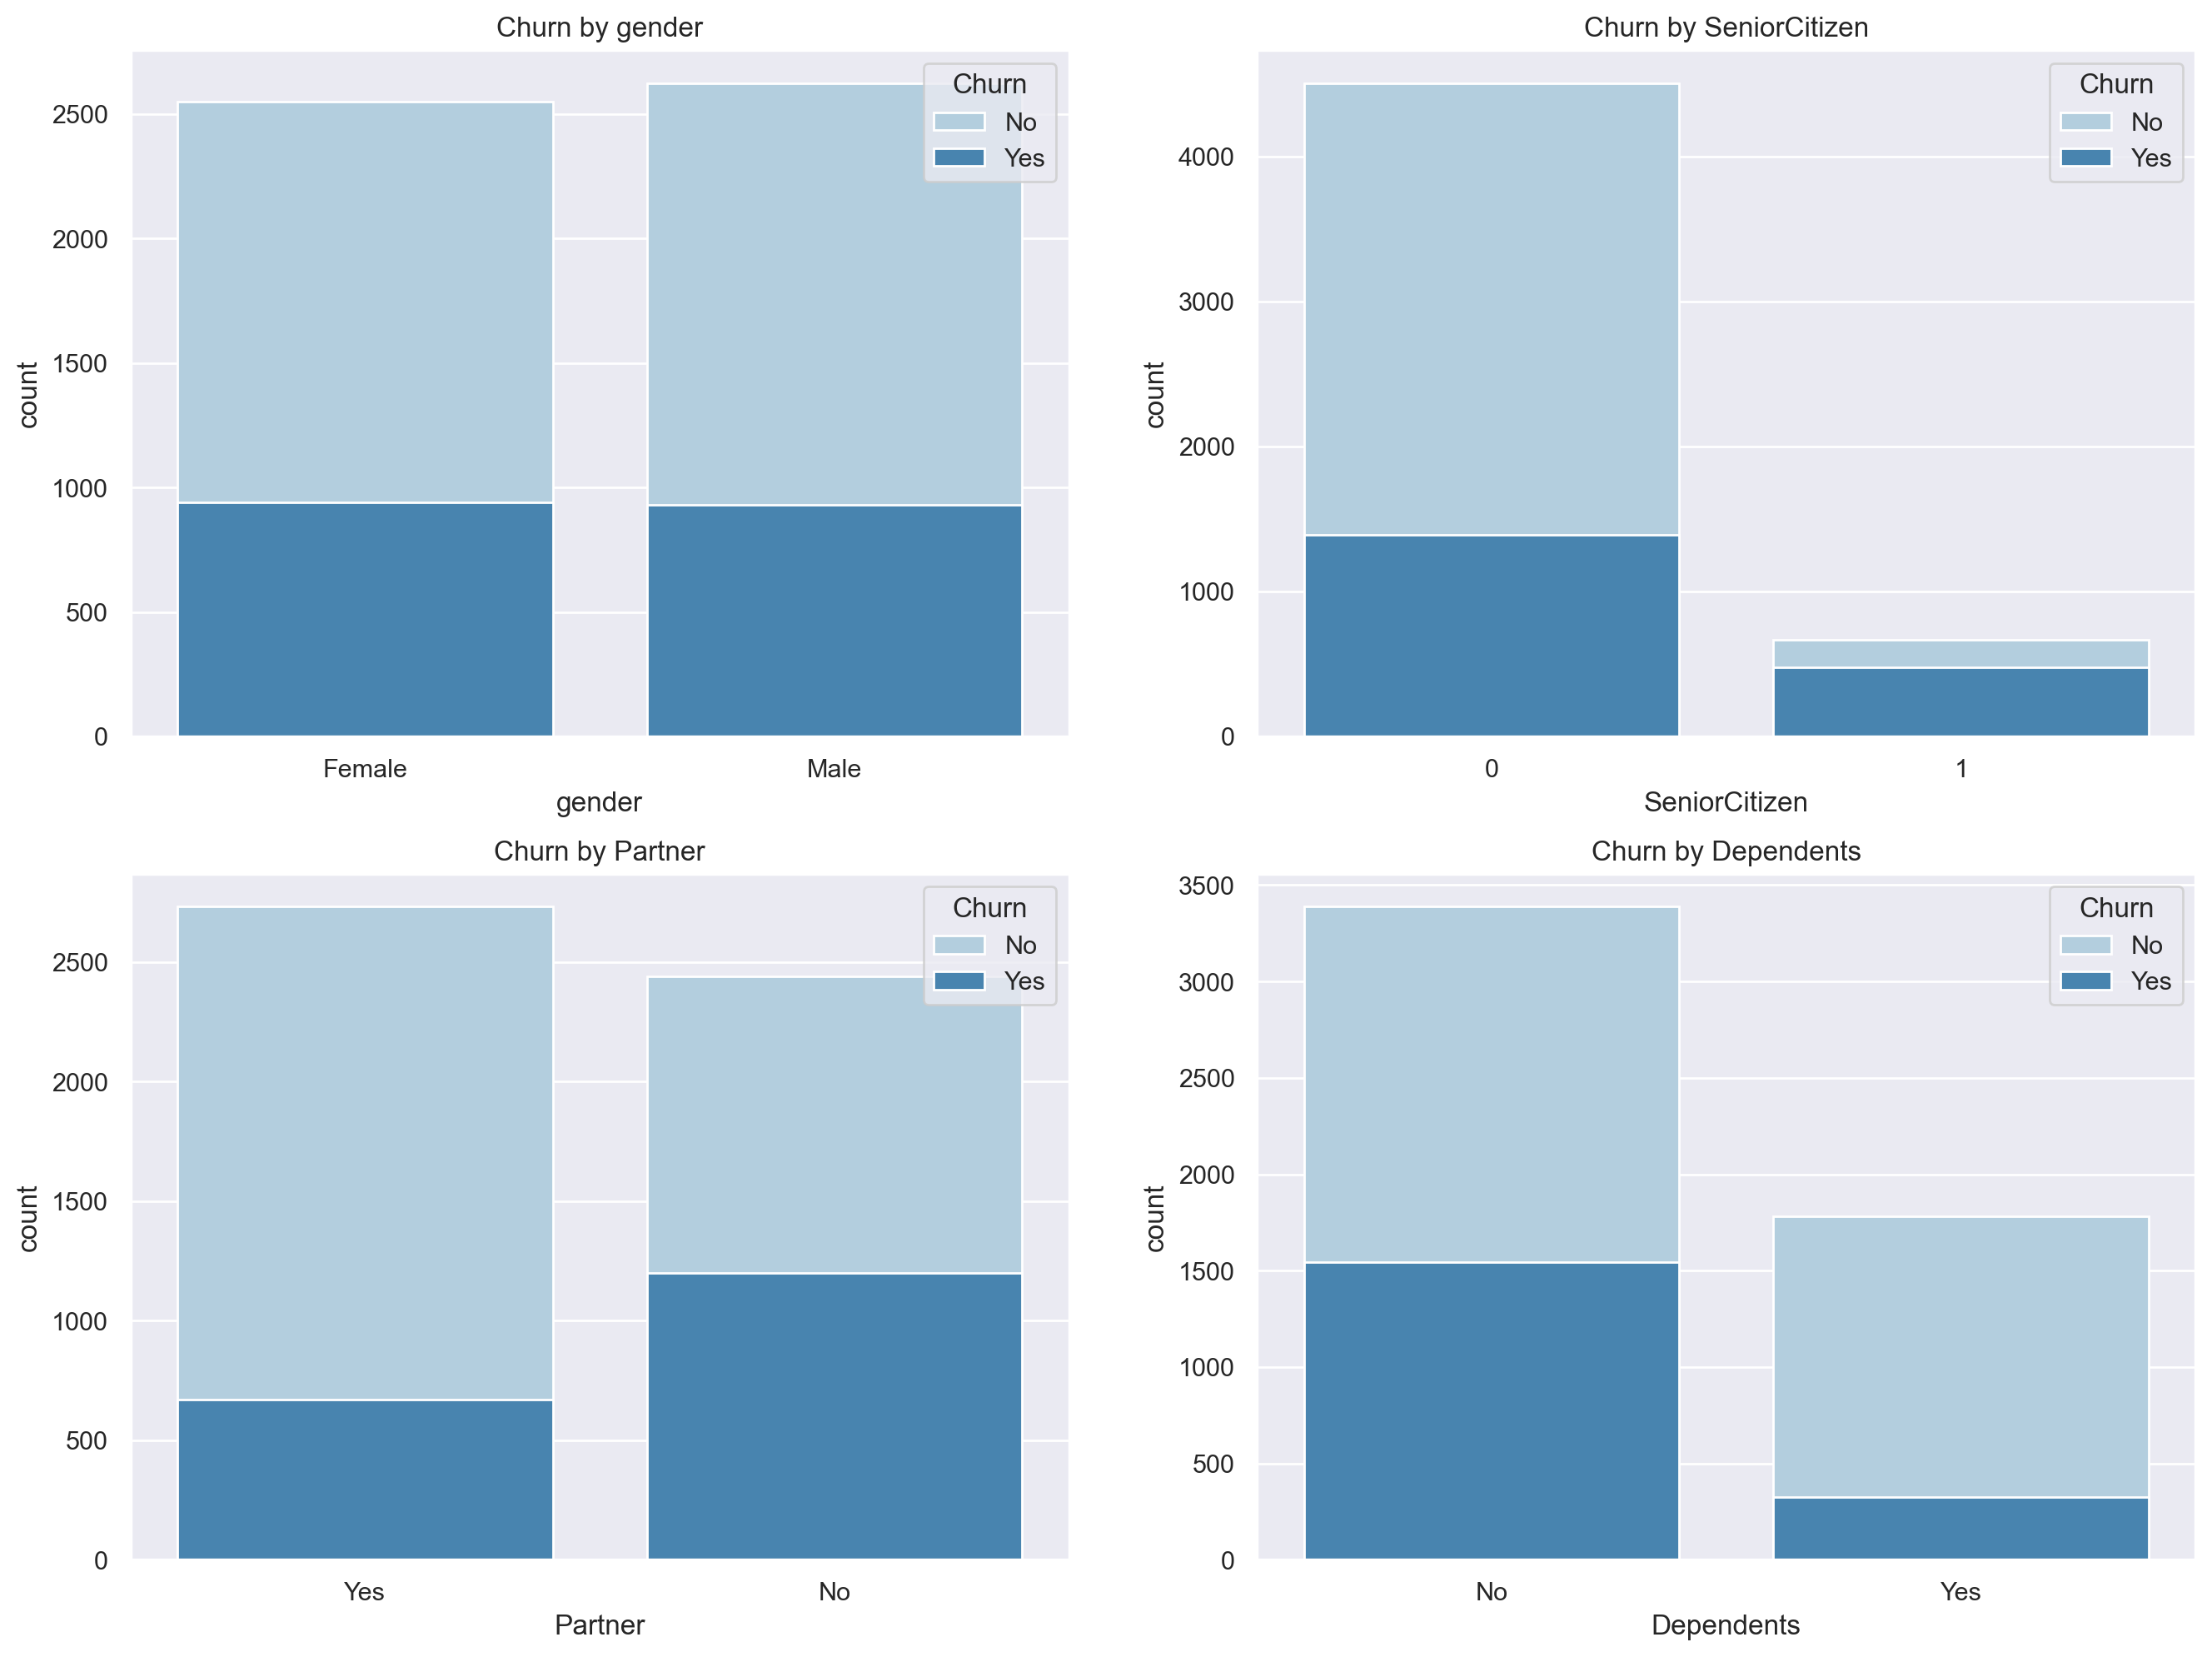

In [85]:
col_1 = ["gender", "SeniorCitizen", "Partner", "Dependents"]

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(16,12), dpi=200)

for i, item in enumerate(col_1):
    plt.subplot(2,2,(i+1)) #subplot 1 2 3 4
    ax=sns.countplot(x=item,hue="Churn",data=tcc,palette="Blues", dodge=False)
    plt.xlabel(item)
    plt.title("Churn by "+ item)

Older customer, those who are not married, and those who are not financially independent have relatively high churn rates, while gender has little impact on churn.

- Service info registered 

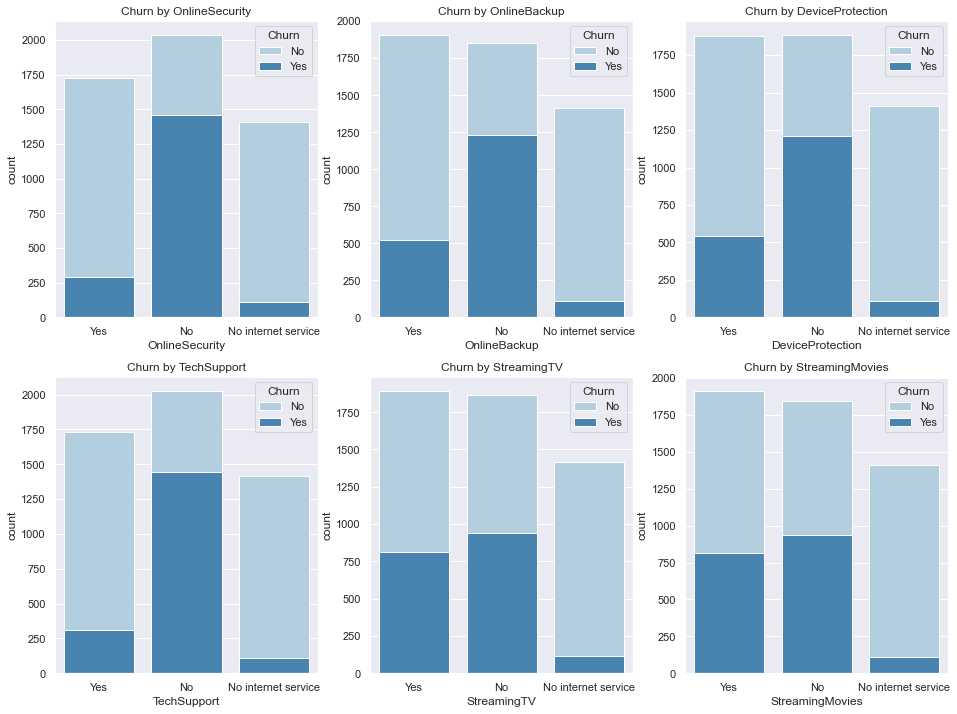

In [86]:
col_2 = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(16,12))

for i, item in enumerate(col_2):
    plt.subplot(2,3,(i+1))
    ax=sns.countplot(x=item,hue="Churn",data=tcc,palette="Blues",order=["Yes","No","No internet service"], dodge=False)
    plt.xlabel(item)
    plt.title("Churn by "+ item)

- Contract type

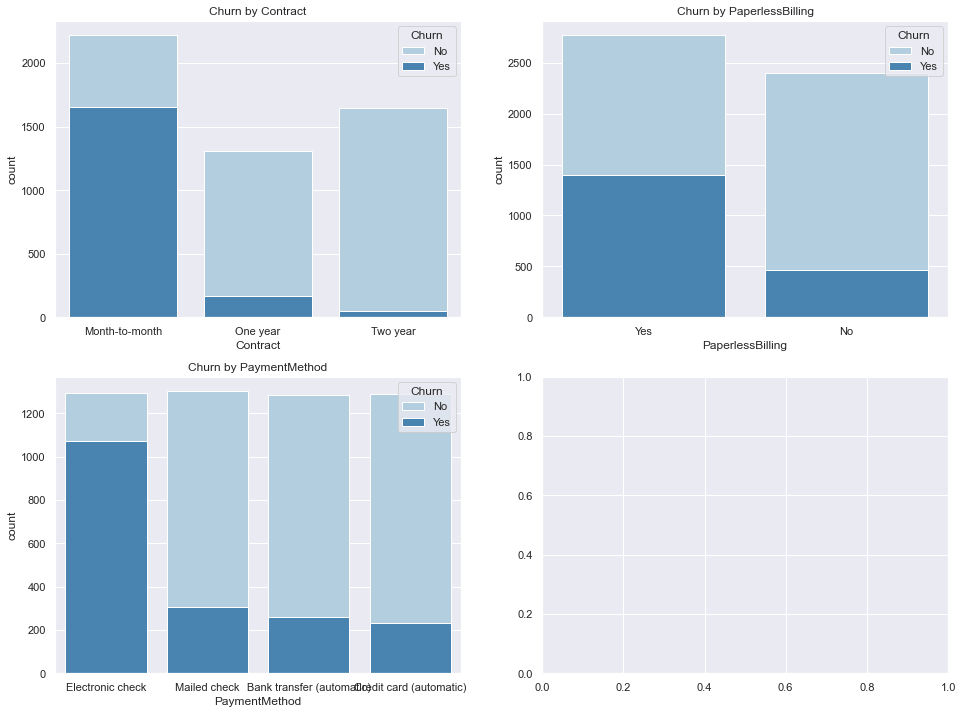

In [87]:
col_3 = ["Contract", "PaperlessBilling", "PaymentMethod"]

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(16,12))

for i, item in enumerate(col_3):
    plt.subplot(2,2,(i+1))
    ax=sns.countplot(x=item,hue="Churn",data=tcc,palette="Blues", dodge=False)
    plt.xlabel(item)
    plt.title("Churn by "+ item)

The shorter the one-time sign-up service cycle, the more likely users are to churn